# Árbol de Decisión — Versión Sencilla (Social_Network_Ads)

**Objetivo:** cargar datos, hacer una **exploración muy básica**, entrenar un **árbol de decisión sencillo**, ver **matriz de confusión** y entender (en lenguaje simple) *precision, recall, f1-score, support*.  
Después veremos: **vista textual del árbol**, **profundidad vs rendimiento** (over/underfitting) y una **frontera de decisión** en 2D.


## 1) Carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\Usuario\Downloads/Social_Network_Ads.csv"
df = pd.read_csv(CSV_PATH)
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


## 2) EDA básico

In [2]:
# Info general y nulos
print("Dimensiones:", df.shape)
df.info()
print("\nNulos por columna:\n", df.isna().sum())

# Detección de columnas típicas del dataset
cols = [c for c in df.columns]
lower = {c: c.lower() for c in cols}

# Target (suele ser 'Purchased')
TARGET = next((c for c in cols if lower[c] in ["purchased", "target", "label"]), cols[-1])

# Evitamos usar ID si existe
id_like = next((c for c in cols if lower[c].replace(" ", "") in ["userid","id"]), None)

# Dos features numéricas más informativas (Age y EstimatedSalary si existen)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
prefer = [c for c in num_cols if lower.get(c,"") in ["age","estimatedsalary"]]
if len(prefer) == 2:
    FEATURES = prefer
else:
    # fallback: toma las dos primeras numéricas que no sean TARGET ni ID
    fallback = [c for c in num_cols if c not in [TARGET, id_like]]
    FEATURES = fallback[:2]

print("TARGET:", TARGET)
print("FEATURES:", FEATURES)

Dimensiones: (400, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User ID          400 non-null    int64  
 1   Gender           400 non-null    object 
 2   Age              400 non-null    float64
 3   EstimatedSalary  400 non-null    float64
 4   Purchased        400 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 15.8+ KB

Nulos por columna:
 User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64
TARGET: Purchased
FEATURES: ['Age', 'EstimatedSalary']


## 3) Entrenamiento muy simple + Matriz de confusión

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

X = df[FEATURES].copy()
y = df[TARGET].copy()

# División en train/test (estratificada si procede)
strat = y if y.nunique() <= 10 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

# Árbol sencillo (poca profundidad para no sobreajustar)
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
cm = confusion_matrix(y_test, pred)
print("Accuracy (test):", acc)
print("Matriz de confusión:\n", cm)

# Informe con precision, recall, f1-score, support
print("\nInforme de clasificación:\n")
print(classification_report(y_test, pred))

Accuracy (test): 0.8625
Matriz de confusión:
 [[45  6]
 [ 5 24]]

Informe de clasificación:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        51
           1       0.80      0.83      0.81        29

    accuracy                           0.86        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.86      0.86      0.86        80



### ¿Qué significan *precision*, *recall*, *f1-score* y *support*?

- **Precision (precisión):** de todas las veces que el modelo dijo **"Sí"**, ¿cuántas eran **"Sí"** de verdad? (evita **falsos positivos**).
- **Recall (exhaustividad):** de todos los **"Sí"** reales, ¿cuántos detectó el modelo? (evita **falsos negativos**).
- **F1-score:** mezcla equilibrada de *precision* y *recall* (media armónica). Útil cuando te importan **ambos**.
- **Support:** cuántos ejemplos de cada clase había realmente en el conjunto de test (tamaño real de cada clase).

> **Tip rápido:** Accuracy puede engañar si las clases están desbalanceadas. Mira también *precision*, *recall* y *f1* de cada clase.


## 4) Vista textual del árbol (reglas en texto)

In [4]:
from sklearn.tree import export_text
tree_text = export_text(clf, feature_names=list(FEATURES))
print(tree_text)

|--- Age <= 44.50
|   |--- EstimatedSalary <= 89500.00
|   |   |--- Age <= 36.50
|   |   |   |--- class: 0
|   |   |--- Age >  36.50
|   |   |   |--- EstimatedSalary <= 72500.00
|   |   |   |   |--- class: 0
|   |   |   |--- EstimatedSalary >  72500.00
|   |   |   |   |--- class: 0
|   |--- EstimatedSalary >  89500.00
|   |   |--- Age <= 26.50
|   |   |   |--- class: 0
|   |   |--- Age >  26.50
|   |   |   |--- EstimatedSalary <= 133500.00
|   |   |   |   |--- class: 1
|   |   |   |--- EstimatedSalary >  133500.00
|   |   |   |   |--- class: 1
|--- Age >  44.50
|   |--- EstimatedSalary <= 41500.00
|   |   |--- class: 1
|   |--- EstimatedSalary >  41500.00
|   |   |--- EstimatedSalary <= 75000.00
|   |   |   |--- Age <= 51.50
|   |   |   |   |--- class: 0
|   |   |   |--- Age >  51.50
|   |   |   |   |--- class: 1
|   |   |--- EstimatedSalary >  75000.00
|   |   |   |--- Age <= 52.50
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  52.50
|   |   |   |   |--- class: 1



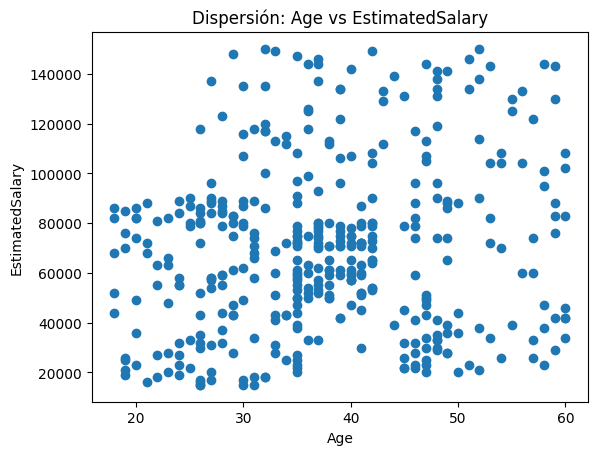

In [7]:
if len(FEATURES) >= 2:
    x1, x2 = FEATURES[0], FEATURES[1]
    plt.figure()
    plt.scatter(df[x1], df[x2])
    plt.title(f"Dispersión: {x1} vs {x2}")
    plt.xlabel(x1); plt.ylabel(x2)
    plt.show()

## 5) Profundidad vs rendimiento (overfitting vs underfitting)

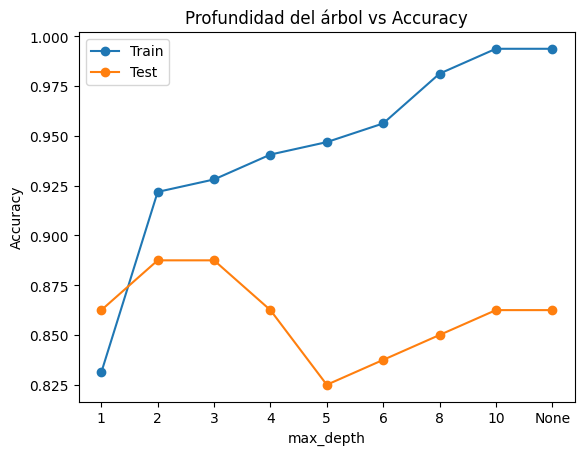

In [5]:
from sklearn.tree import DecisionTreeClassifier

depths = [1,2,3,4,5,6,8,10,None]
train_scores, test_scores = [], []
for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure()
plt.plot([str(d) for d in depths], train_scores, marker="o", label="Train")
plt.plot([str(d) for d in depths], test_scores, marker="o", label="Test")
plt.title("Profundidad del árbol vs Accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Cómo leer la gráfica:**

- **Poca profundidad (1–2):** el árbol es muy simple → **infrap ajuste** (*underfitting*): baja en train y test.
- **Profundidad media (3–6):** suele haber **mejor equilibrio** entre train y test.
- **Mucha profundidad (8–∞):** el árbol memoriza el train → **sobreajuste** (*overfitting*): train muy alto, test empeora.


## 6) Frontera de decisión (2D)

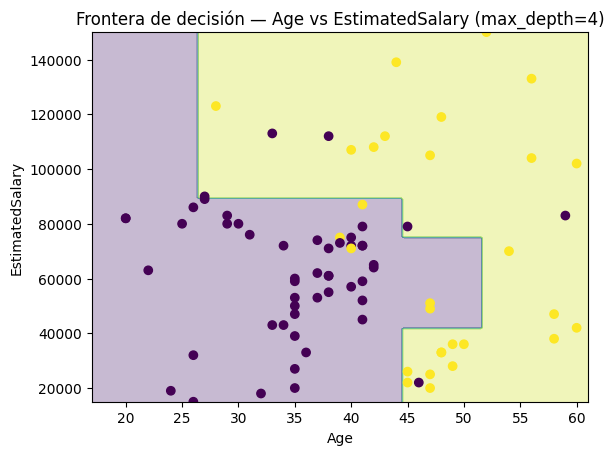

In [6]:
# Solo tiene sentido con DOS features numéricas
if len(FEATURES) == 2:
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeClassifier

    X2 = df[FEATURES].values
    y2 = df[TARGET].values
    X2_train, X2_test, y2_train, y2_test = train_test_split(
        X2, y2, test_size=0.2, random_state=42, stratify=strat
    )
    dt2 = DecisionTreeClassifier(max_depth=4, random_state=42)
    dt2.fit(X2_train, y2_train)

    x_min, x_max = X2[:,0].min()-1, X2[:,0].max()+1
    y_min, y_max = X2[:,1].min()-1, X2[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = dt2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X2_test[:,0], X2_test[:,1], c=y2_test)
    plt.title(f"Frontera de decisión — {FEATURES[0]} vs {FEATURES[1]} (max_depth=4)")
    plt.xlabel(FEATURES[0]); plt.ylabel(FEATURES[1])
    plt.show()
else:
    print("Para ver la frontera de decisión, deja exactamente 2 columnas numéricas en FEATURES.")

## 7) Preguntas

1. **Baja `max_depth` a 2** y luego **sube a 6**. ¿Cómo cambian las predicciones?
2. **Aumenta `test_size` a 0.4.** ¿Notas que la accuracy de test cambia más entre ejecuciones?
3. **Usa solo una feature** (por ejemplo `Age`). ¿Qué pierde el modelo?
4. **Quita posibles IDs** de `FEATURES` si existen. ¿Por qué no deben usarse para predecir?
6. **Clase minoritaria:** mira `value_counts()` del TARGET. ¿La accuracy por sí sola puede engañar?
7. **`min_samples_split=50`.** ¿El árbol se simplifica? ¿Aumenta o baja la accuracy de test?
8. **Cambia `random_state`.** ¿Se modifica visiblemente la frontera de decisión?
9. **Reglas en texto:** lee 2 reglas del `export_text` y explica en 1 línea qué significan.
10. Con lo que has visto, ¿qué `max_depth` usarías para este dataset y por qué? (2 líneas).
